In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT


%load_ext autoreload
%autoreload 2

In [8]:
expers_to_load = [# Meta V1 model regression
                  (False, "run_20170922_10_22_24_metaV1_70ep_5ops_lr4e05"), 
                  (False, "run_20171001_11_05_13_metaV1_20ep_5ops_lr4e05"), # True
                  (False, "run_20170922_10_35_38_metaV1_65ep_10ops_lr4e05"), 
                  (False, "run_20171001_11_17_59_metaV1_20ep_10ops_lr4e05"), # True
                  (False, "run_20171001_10_20_09_metaV1_55ep_25ops_lr4e05"), # trunc_bptt_step=20  True
                  (True, "run_20170925_14_31_57_metaV1_100ep_50ops_lr4e05"), # =50
                  (True, "run_20170925_11_55_49_metaV1_65ep_50ops_lr4e05"), # =20   True
                  (True, "run_20170925_12_23_03_metaV1_40ep_50ops_lr4e05"), # =10
                  (True, "run_20171001_17_57_19_metaV1_30ep_50ops_lr4e05"), # =5  
                  (True, "run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05")] # =100  True



In [9]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 35

without_models = False

path_ext = None
experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        if path_ext is not None:
            exp_file_path = os.path.join(path_ext, exp_path[1])
        else:
            exp_file_path = exp_path[1]
            
        exp = Experiment.load(exp_file_path, do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            num_inputs = 1
            if exp.args.problem == 'mlp':
                num_inputs = 3
            models.append(get_model(exp, num_inputs, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config, set_seed=True))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger
        new_experiments[-1].validation_handler_class = experiments[-1].validation_handler_class
        new_experiments[-1].training_horizon = experiments[-1].config.T
        new_experiments[-1].avg_num_opt_steps = experiments[-1].avg_num_opt_steps

INFO - created local logger for experiment with model metaV1_regression_50ops
INFO - INFO - loaded existing model from file logs/run_20170925_14_31_57_metaV1_100ep_50ops_lr4e05/metaV1_regression_50ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
INFO - created local logger for experiment with model metaV1_regression_50ops
INFO - INFO - loaded existing model from file logs/run_20170925_11_55_49_metaV1_65ep_50ops_lr4e05/metaV1_regression_50ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weig

0 Loading model metaV1_regression_50ops / run_20170925_14_31_57_metaV1_100ep_50ops_lr4e05
1 Loading model metaV1_regression_50ops / run_20170925_11_55_49_metaV1_65ep_50ops_lr4e05
2 Loading model metaV1_regression_50ops / run_20170925_12_23_03_metaV1_40ep_50ops_lr4e05
3 Loading model metaV1_regression_50ops / run_20171001_17_57_19_metaV1_30ep_50ops_lr4e05
4 Loading model metaV1_regression_100ops / run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05


In [10]:
# del new_experiments
new_experiments = []
unrolled_steps=100
num_of_funcs = 10000

if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for exper in expers_to_load:
    if exper[0]:
        
        path_to_exp = exper[1] + "/" + "exp_eval_stats_" + str(num_of_funcs) + "_" + str(unrolled_steps) +"steps.dll"
        print("Loading experiment {} / path {}".format(exper[1], path_to_exp))
        new_experiments.append(Experiment.load(path_to_exp=path_to_exp,
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20170925_14_31_57_metaV1_100ep_50ops_lr4e05 / path run_20170925_14_31_57_metaV1_100ep_50ops_lr4e05/exp_eval_stats_10000_100steps.dll
Loading experiment run_20170925_11_55_49_metaV1_65ep_50ops_lr4e05 / path run_20170925_11_55_49_metaV1_65ep_50ops_lr4e05/exp_eval_stats_10000_100steps.dll
Loading experiment run_20170925_12_23_03_metaV1_40ep_50ops_lr4e05 / path run_20170925_12_23_03_metaV1_40ep_50ops_lr4e05/exp_eval_stats_10000_100steps.dll
Loading experiment run_20171001_17_57_19_metaV1_30ep_50ops_lr4e05 / path run_20171001_17_57_19_metaV1_30ep_50ops_lr4e05/exp_eval_stats_10000_100steps.dll
Loading experiment run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05 / path run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05/exp_eval_stats_10000_100steps.dll
Ready


In [6]:
with open("data/test_regression_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


INFO - Successfully saved fig figures/10reg_LSTM_effect_BPTT_0_5.png


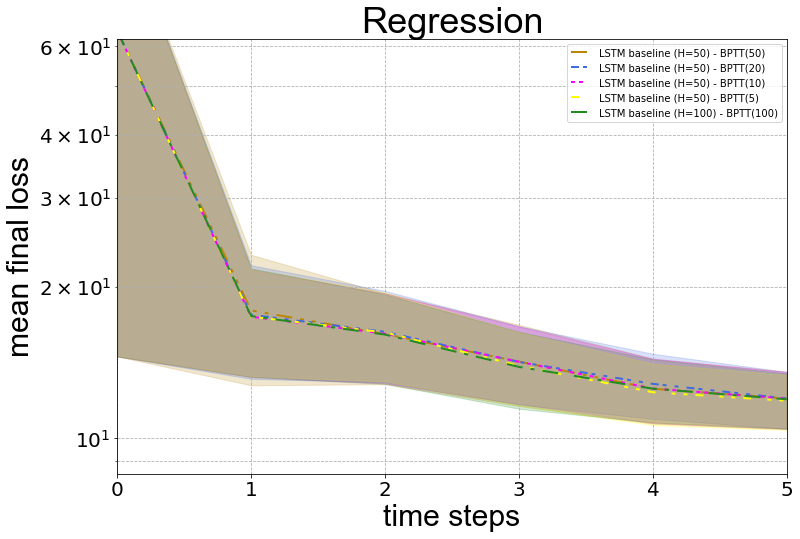

In [15]:
# new_exp_select = [new_experiments[0], new_experiments[1], new_experiments[2], new_experiments[4],
#                 new_experiments[6]] 
#, new_experiments[4]] 
part = 1
if part == 1:
    min_step = 0
    max_step = 5
    y_lim=[8.5, 62]
    log_scale  = True
elif part == 2:
    min_step = 5
    max_step = 100
    log_scale = True
    y_lim=[8.5, 12.5]
else:
    log_scale = True
    min_step = 0
    max_step = 100
    y_lim=[8.5, 62]
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="10reg_LSTM_effect_BPTT_" + str(min_step) + "_" + str(max_step),  
                                              loss_type="loss",
                                              min_step=min_step,
                                              max_step=max_step,
                                              sort_exper="Regression",
                                              log_scale=log_scale,
                                              y_lim=y_lim,
                                              with_stddev=True,
                                              runID=None)
# label_annotation=[" - BPTT(50)", " - BPTT(20)", " - BPTT(10)", " - BPTT(5)", " - BPTT(100)"]

In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [7]:
exp_idx = 0
model = models[exp_idx]

max_steps = 100
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "geometric"


epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model metaV1_regression_50ops with 10000 functions


Validating model metaV1_regression_50ops with q-prob 0.900


INFO - INFO - Epoch 400, elapsed time 4.15 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 1.06e+03/9.473/0.2835
INFO - INFO - Epoch 400: Final step losses: [ 64.415  17.43   16.217  13.928  12.338  11.869  11.618  11.212  10.87
  10.741  10.648  10.498  10.362  10.28   10.228  10.168  10.109  10.064
  10.027   9.99    9.954   9.922   9.895   9.87    9.846   9.825   9.806
   9.789   9.772   9.757   9.743   9.729   9.717   9.705   9.694   9.684
   9.675   9.666   9.657   9.649   9.642   9.634   9.628   9.621   9.615
   9.609   9.604   9.598   9.593   9.588   9.584   9.58    9.575   9.571
   9.567   9.564   9.56    9.557   9.553   9.55    9.547   9.544   9.541
   9.538   9.536   9.533   9.53    9.528   9.526   9.523   9.521   9.519
   9.517   9.515   9.513   9.511   9.509   9.507   9.505   9.503   9.502
   9.5     9.498   9.496   9.495   9.493   9.492   9.491   9.489   9.488
   9.486   9.484   9.483   9.482   9.481   9.479 

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [16]:

exp_idx = 0
max_steps = 200
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model metaV1_regression_50ops with 10000 functions


Validating model metaV1_regression_50ops with q-prob 0.500


INFO - INFO - Epoch 400, elapsed time 7.96 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 2.005e+03/9.396/0.2067
INFO - INFO - Epoch 400: Final step losses: [ 64.415  17.634  15.952  14.081  12.497  11.925  11.602  11.241  10.939
  10.779  10.673  10.527  10.394  10.323  10.27   10.207  10.142  10.089
  10.055  10.024   9.991   9.957   9.927   9.903   9.882   9.862   9.842
   9.823   9.806   9.79    9.776   9.762   9.749   9.737   9.725   9.714
   9.704   9.695   9.685   9.677   9.669   9.661   9.653   9.646   9.64
   9.633   9.627   9.621   9.615   9.61    9.605   9.6     9.595   9.591
   9.586   9.582   9.578   9.574   9.57    9.567   9.563   9.56    9.556
   9.553   9.55    9.547   9.544   9.541   9.538   9.536   9.533   9.53
   9.528   9.525   9.523   9.521   9.519   9.516   9.514   9.512   9.51
   9.508   9.506   9.504   9.502   9.5     9.498   9.497   9.495   9.493
   9.492   9.49    9.488   9.487   9.485   9.484  

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05/loss_metaV1_50ep_100ops_21:43:29.png


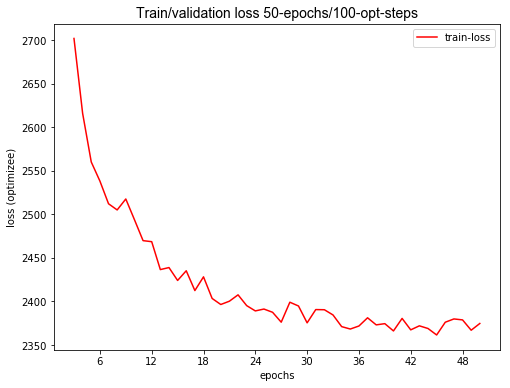

In [41]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

In [ ]:
plot_actsb_qts(new_experiments[3], data_set="eval", save=False, show=True, add_info=False, epoch=400, 
              fig_name="qt_dist_test_eval_500steps")

INFO - Successfully saved fig logs/run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05/T_dist_eval.png


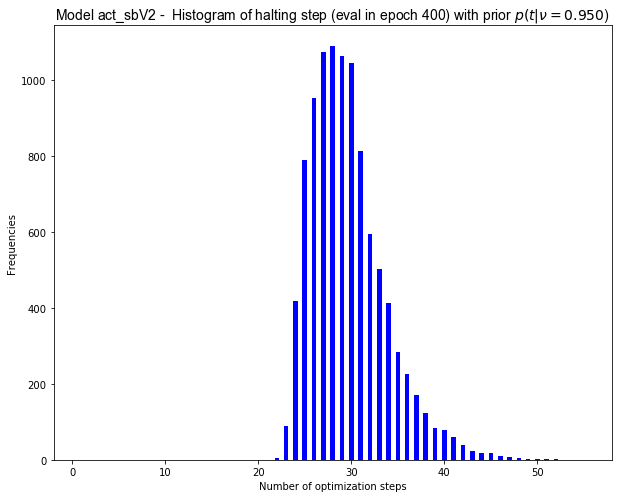

In [79]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400)

INFO - Successfully saved fig logs/run_20170829_17_23_19_act_sbV3.1_65ep_nu0.6_lr5e05/halting_step_versus_nll_distance.png


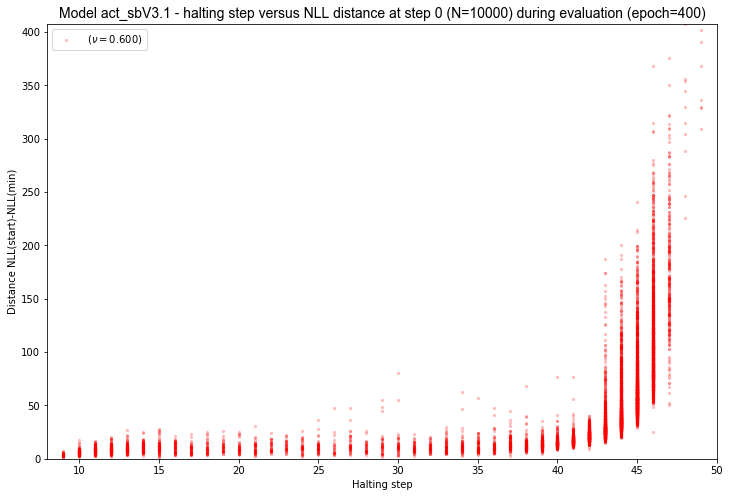

In [6]:
plot_loss_versus_halting_step(new_experiments[1], epoch=400, do_show=True, do_save=True)

INFO - Successfully saved fig logs/run_20171001_17_57_19_metaV1_30ep_50ops_lr4e05/10dreg_50ops_5bptt_15ep_5steps.png


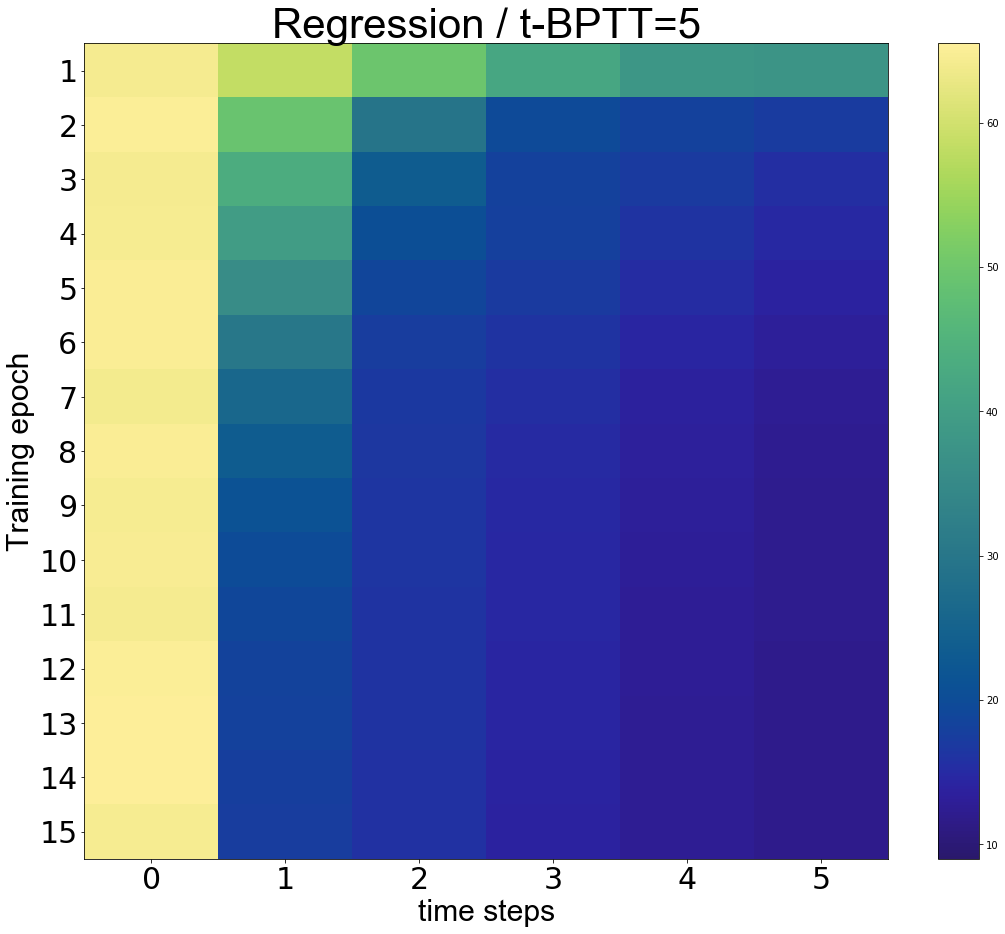

In [8]:
plot_image_map_losses(experiments[0], fig_name="10dreg_50ops_5bptt_15ep_5steps", do_save=True, do_show=True, 
                      max_epoch=15, max_time_step=6, fig_title="Regression / t-BPTT=5", huge=True)

In [5]:
"""
    Generate new test functions
"""
test_funcs = RegressionWithStudentT(n_funcs=10000, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)
with open("data/test_regression_T_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")


Ready


In [5]:
funcs = RegressionFunction(n_funcs=10, n_samples=10, stddev=1., x_dim=5, use_cuda=True, 
                                calc_true_params=False)
print(funcs.true_minimum_nll)

Variable containing:
 9.1894
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [3]:
test_funcs = RegressionFunction(n_funcs=10000, n_samples=10, stddev=1., x_dim=10, use_cuda=True, 
                                calc_true_params=False)
with open("data/test_regression_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [15]:
experiments[6].generate_figures()

INFO - Successfully saved fig logs/run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05/loss_train_metaV1_40ep_100ops.png
(100, 40)
INFO - Successfully saved fig logs/run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05/loss_optimizer_train_metaV1_40ep_100ops.png
INFO - Successfully saved fig logs/run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05/loss_eval_metaV1_40ep_100ops.png
(100, 40)
INFO - Successfully saved fig logs/run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05/loss_optimizer_eval_metaV1_40ep_100ops.png
INFO - Successfully saved fig logs/run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05/train_step_loss_map_metaV1_40ep_100ops.png
INFO - Successfully saved fig logs/run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05/T_dist_train.png
INFO - Successfully saved fig logs/run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05/gradient_statistics.png
INFO - Successfully saved fig logs/run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05/eval_step_loss_map_metaV1_40ep_100ops.png
